In [1]:
%matplotlib notebook
import torch.nn as nn
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import webdataset as wds
import glob
from torchvision import transforms
import imgaug.augmenters as iaa
from webdataset.handlers import ignore_and_continue
from PIL import Image
import io
from pytorch3d.transforms import euler_angles_to_matrix
from pytorch3d.transforms import matrix_to_euler_angles
from mpl_toolkits.mplot3d import axes3d 
from copy import deepcopy

In [2]:
iaa_valid = iaa.Resize((368, 368))
def parse_euler(x, joint_indices):
    x = x.decode("utf-8").split(",") 
    x = np.array(x).astype(float).reshape(-1,6)[joint_indices]
    return x
    
    
def transform3D(x, joint_indices):
    x = x.decode("utf-8").split(",")
    x = np.array(x).astype(float).reshape(-1,3)[joint_indices]
    
    return x.reshape(-1)
 

def pil_decode(data, augment=False):
    img = np.array(Image.open(io.BytesIO(data)))
    if augment:
        img = seq(images=[img])[0] 
    else:
        img = iaa_valid(images=[img])[0]
    img = Image.fromarray(img)

    return img
    

def decode_train(sample):
    return decode_sample(sample)
preproc = transforms.Compose([
    transforms.ToTensor(),
])
def decode_sample(sample): 
    print(sample["__key__"])
    # hip, spine1, spine2, thorax
    # right shoulder, right arm, right forearm, right hand
    # left shoulder, left arm, left forearm, left hand 
    
    # https://github.com/facebookresearch/xR-EgoPose/blob/main/utils/config.py
    # kinematic tree
    joint_indices = [0, 2, 3, 4, 13, 14, 15, 16,21, 22, 23, 24]
    pose_img = preproc(pil_decode(sample["pose_image.png"]))
    pose_3dp = transform3D(sample["pose_3dp.csv"], joint_indices)
    rot_3dp = parse_euler(sample["pose_3da_rot.csv"], joint_indices)

    return dict(
        image=pose_img,
        pose=pose_3dp,
        rotation=rot_3dp
    )


In [3]:
test_path = "/egopose-data/web-datasets/xrEgoPose_trainset_male_004_a_a_env_001_000.tar"
test_url = glob.glob(test_path)
ds_test = wds.WebDataset(test_url).map(decode_train).to_tuple("image", "pose", "rotation")
test_loader = torch.utils.data.DataLoader(ds_test, num_workers=0, batch_size=1)

In [251]:
# def swap(translation, seq="XYZ"):
#     order = {"X":0, "Y":1, "Z":2}
#     new_order = [translation[order[seq[0]]], translation[order[seq[1]]], translation[order[seq[2]]] ]
#     return np.array(new_order)

def test_forward(rot_trans, order="XYZ"): #
    matrices = []
    offsets = []
    positions = [deepcopy(rot_trans[0][3:]) ]
    for ind, rot_tran in enumerate(rot_trans):
        angles = rot_tran[:3] # first 3 values are euler angles (xyz) 
            
        print(ind,"Angle Differnece:", angles.tolist())
        trans = rot_tran[3:] # last three values are translations 

        angles = np.radians(angles) 
        rot_matrix = euler_angles_to_matrix(angles, order) # 3x3 rotation matrix
        matrices.append(rot_matrix)
        offsets.append(trans)
    for i in range(1, len(matrices)):        
        offsets[i][-1] *= -1 # translation in Z is reversed
        position = np.matmul(offsets[i], matrices[i-1])
        positions.append(position + positions[i-1])
        matrices[i] = np.matmul(matrices[i], matrices[i-1]) 
        

    return positions

def plot(positions1, positions2):
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim([-25, 5])
    ax.set_ylim([-25, -1])
    ax.set_zlim([-35, 35])
    
    for position, color in zip([positions, positions2], ("red", "green")):
        first = deepcopy(position[0])
        for ind, pos in enumerate(position):
#             pos -= first # subtract first joint
            ax.scatter(pos[0], pos[1], pos[2], color=color)

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

    plt.show()

def preprocess_translation(translations, gt):
    """
    Starting position is starting position of gt pose
    translations = difference of subsequent translations in the orignal json
    angles = difference between subsequent angles in orignal json
    starting angle = 0, 0, 0 (Identity Matrix)
    """
    start = deepcopy(translations)
    for i in range(1, len(translations)):
        translations[i][3:] = deepcopy(translations[i][3:]-start[i-1][3:])
        translations[i][:3] = deepcopy(translations[i][:3]-start[i-1][:3])
    translations[0][3:] = gt[0]
    translations[0][:3] = torch.tensor([0,0,0])
    return translations
    

xrEgoPose_trainset_male_004_a_a_env_001_000/male_004_a_a_000001
joint angles orig:  [-0.022984761007277768, -0.0024393805675177057, -0.037588692248673325]
joint angles orig:  [-4.372923378974073, -0.002317069835213297, -0.041930061920523655]
joint angles orig:  [-4.3729221020023585, -0.002317069835213297, -0.041930061920523655]
joint angles orig:  [-4.3729221020023585, -0.002317069835213297, -0.041930061920523655]
joint angles orig:  [-16.62945660417255, -84.78582757277867, 122.84861566076417]
joint angles orig:  [1.090166311493625, -84.56283692567455, 88.95143513801781]

translations orig:  [1.0962374210357666, -3.6041412353515625, 106.64535522460938]
translations orig:  [1.1024534702301028, -4.325096607208252, 116.07362365722658]
translations orig:  [1.1105371713638306, -5.166243553161621, 127.07325744628906]
translations orig:  [1.1197757321328279, -6.12755392021052, 139.6442625616264]
translations orig:  [-6.547713756561279, -7.419287204742432, 151.54267883300776]
translations orig

<IPython.core.display.Javascript object>


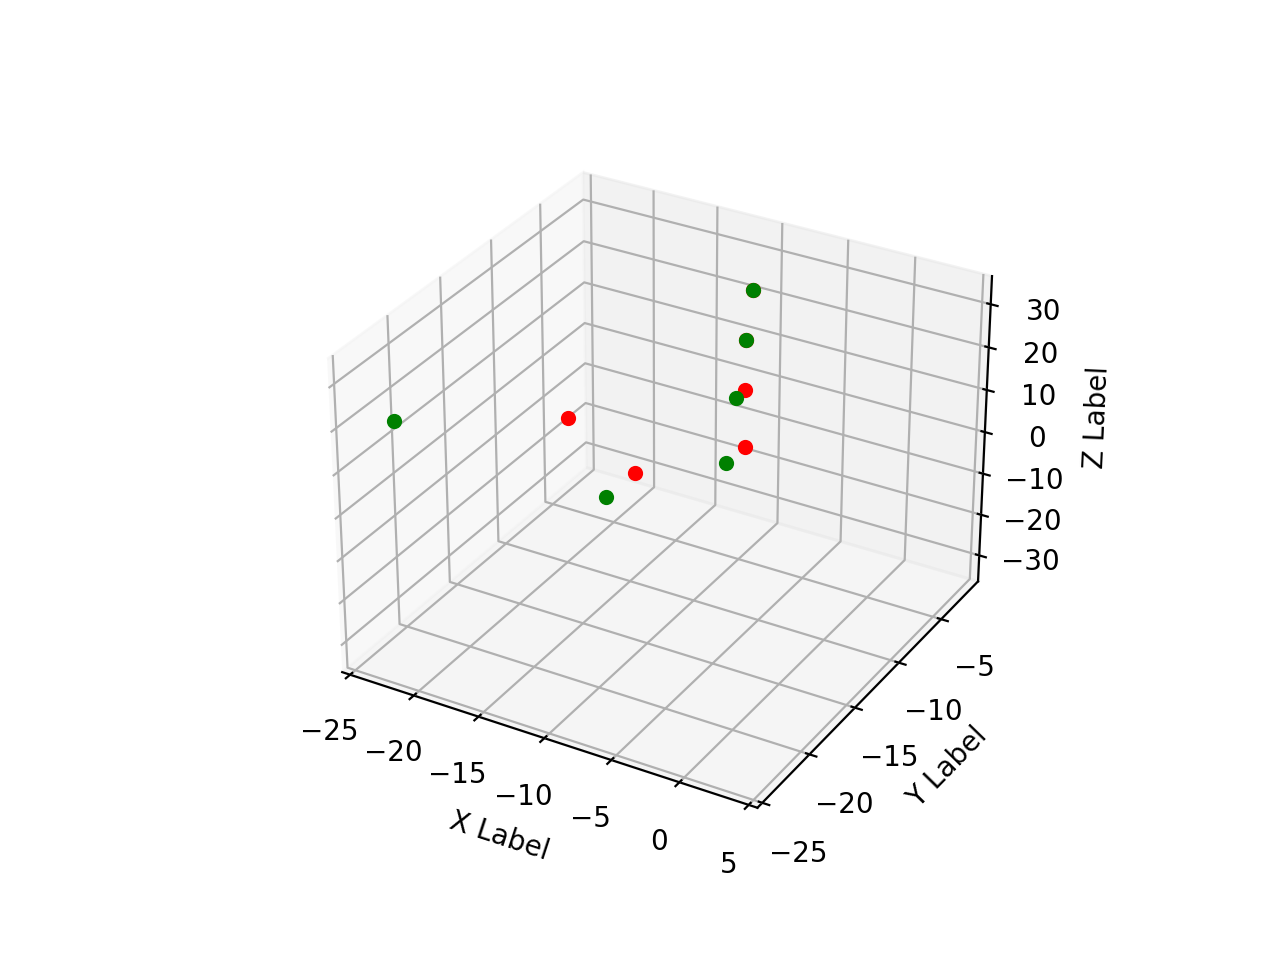

In [252]:
for i, sample in enumerate(test_loader):
    joint_angles = sample[2][0][[0,1,2,3,4,5]] # Translatoins and Angles 
    for i in range(len(joint_angles)):
        print("joint angles orig: ", joint_angles[i][:3].tolist())
    print()
    
    # SWAP Translation of Z with Y
    joint_angles[:,[4, 5]] = joint_angles[:,[5, 4]]
    for i in range(len(joint_angles)):
        print("translations orig: ", joint_angles[i][3:].tolist())
    print()
    
    gt_pose = sample[1][0].reshape(-1,3)[[0,1, 2, 3,4, 5]] # gt 3d pose
    for i in range(len(joint_angles)):
        print("gt pose: ", gt_pose[i])
    print()
    # Translatoins and rotations are the difference with previous joints
    joint_angles = preprocess_translation(joint_angles, gt_pose)

    positions = test_forward(joint_angles, "XYZ") # hip, spine(3), shoulder, arm, forearm, hand (right)
    print("\n")
    
    for ind, position in enumerate(positions):
        print(ind, "FK pose", position.tolist())
    plot(positions, gt_pose)

    break

    

   

In [ ]:
def test_angles(angles):
    orig_angles = angles
    print(orig_angles)
    angles = np.radians(angles)
    rot_matrix = euler_angles_to_matrix(angles, "XYZ")
    angles = matrix_to_euler_angles(rot_matrix, "XYZ")
    angles = np.degrees(angles)
    print(angles)
    print("\n")
